In [1]:
import numpy as np
import scipy
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from matplotlib import transforms as tr
import control
from control import matlab
from matplotlib import cm
import matplotlib

np.random.seed(0)
dev = "cpu"  
device = torch.device(dev) 

In [2]:
sysA = np.array([[1.000,0.0008],[0.0013,1.0]])
#sysA = 0.99
sysB = np.array([[0.04],[0.0]])
sysC = np.array([0,2])
sysD = 0
print(np.linalg.eig(sysA))
kp = 20.0
ki = 2.0
kd = 5.0
Tf = 0.01

(array([1.0010198, 0.9989802]), array([[ 0.6172134 , -0.6172134 ],
       [ 0.78679579,  0.78679579]]))


In [3]:
T = 2000
refs = np.zeros((30,T))
np.random.seed(2)

randval = 0

for i in range(30):
  refs[i,0:300] = 0
  randval = 5.8*np.random.rand()-2.9
  print(randval)  
  if randval>0 and randval<1:
    randval = 1
  if randval<0 and randval>-1:
    randval = -1
  refs[i,300:] = randval

-0.37122956757637837
-2.7496278553982303
0.28804237169651303
-0.37513012281399405
-0.46186674789256355
-0.9840580381775301
-1.7130379225805135
0.6917716048338494
-1.1620028926877657
-1.3524018044033734
0.7025762300619105
0.16902414680682654
-2.1194363169993853
0.07875310334132912
-1.8302487792478914
1.6549438573367063
2.0530566973090347
-0.03342634318481874
2.010056615073314
-2.4380562333474463
0.030427322705882887
-2.521338274556107
-0.41689049993514127
-2.340120689168447
-2.162472164132591
0.5611227920758557
-1.589130396495432
-2.2797150310020986
-1.6222239989907536
-0.8710075469808642


In [8]:
ref = refs[1,:]
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))
xcont = 0
u = 0
D = 0
ad = Tf/(Tf+0.01)
bd = kd/(Tf+0.01)
noise = 0.0005*np.random.randn(T,1)

x0 = np.zeros((2,1))
x = x0
for i in range(T):
   ysat[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+(ref[i]-ysat[i])
   if(i>0):
     D = ad*D-bd*(ysat[i]-ysat[i-1])  
     u = 0.01*ki*xcont+kp*(ref[i]-ysat[i])+D
   if(u>3.0):
     u=3.0
   elif(u<-3.0):
     u=-3.0
   uvalssat[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

ynosat = np.zeros((T,))
uvalsnosat = np.zeros((T,))
xcont = 0;
u = 0;
x = x0
D = 0

for i in range(T):
   ynosat[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+(ref[i]-ynosat[i])
   if(i>0):
     D = ad*D-bd*(ynosat[i]-ynosat[i-1])  
     u = 0.01*ki*xcont+kp*(ref[i]-ynosat[i])+D 
   uvalsnosat[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

ybackc = np.zeros((T,))
uvalsbackc = np.zeros((T,))
xcont = 0
u = 0
ucmd = 0
D = 0
ad = Tf/(Tf+0.01)
bd = kd/(Tf+0.01)
back = 1.0

x = x0
for i in range(T):
   ybackc[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+ki*(ref[i]-ybackc[i])+back*(u-ucmd)
   if(i>0):
     D = ad*D-bd*(ybackc[i]-ybackc[i-1])  
     ucmd = 0.01*xcont+kp*(ref[i]-ybackc[i])+D
   if(ucmd>3.0):
     u=3.0
   elif(ucmd<-3.0):
     u=-3.0
   else:
     u = ucmd
   uvalsbackc[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);    

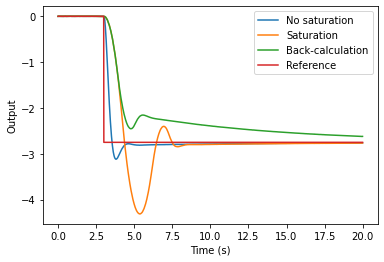

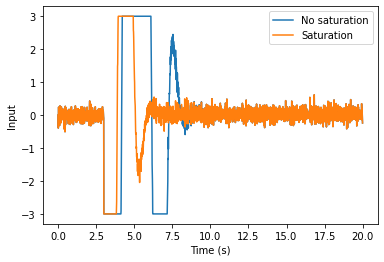

In [9]:
plt.figure
plt.plot(0.01*np.arange(T),ynosat)
plt.plot(0.01*np.arange(T),ysat)
plt.plot(0.01*np.arange(T),ybackc)
plt.plot(0.01*np.arange(T),ref)
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend(["No saturation","Saturation","Back-calculation","Reference"])
plt.show()

plt.figure
#plt.plot(0.01*np.arange(T),uvalsnosat)
plt.plot(0.01*np.arange(T),uvalssat)
plt.plot(0.01*np.arange(T),uvalsbackc)
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.legend(["No saturation","Saturation","Back-calculation"])
plt.show()

In [10]:
class neuralPID(torch.nn.Module):
   def __init__(self):
    super(neuralPID, self).__init__()
    torch.manual_seed(2)
    self.kplayer1 = torch.nn.Linear(2,4)
    self.kplayer2 = torch.nn.Linear(4,1)
    self.kilayer1 = torch.nn.Linear(2,4)
    self.kilayer2 = torch.nn.Linear(4,1)
    self.kdlayer1 = torch.nn.Linear(2,4)
    self.kdlayer2 = torch.nn.Linear(4,1)
    self.backlayer1 = torch.nn.Linear(2,4)
    self.backlayer2 = torch.nn.Linear(4,1)
  
   def forward(self,x):
    sigmoid = torch.nn.Tanh()
    kp = self.kplayer2(sigmoid(self.kplayer1(x)))
    ki = self.kilayer2(sigmoid(self.kilayer1(x)))
    kd = self.kdlayer2(sigmoid(self.kdlayer1(x)))
    back = self.backlayer2(sigmoid(self.backlayer1(x)))
    #kd = torch.clamp(kd,0,400)
    #kp = torch.clamp(kp,0,400)
    #ki = torch.clamp(ki,0,400)
    return kp,ki,kd,back

In [11]:
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

In [13]:
costinit = np.zeros((30,))
costinitback = np.zeros((30,))

yinit = np.zeros((30,T))
uinit = np.zeros((30,T))

yinitback = np.zeros((30,T))
uinitback = np.zeros((30,T))

Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

for iters in range(0,30):
  ref = refs[iters,:]
  reft = torch.tensor(ref)
  noise = 0.0005*torch.randn(T,1)

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinit[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+err
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       u = (0.01*kiit*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(u,-3.0,3.0)
    uinit[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinit[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinitback[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+kiit*err+backit*(u-ucmd)
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(ucmd,-3.0,3.0)
    uinitback[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinitback[iters] = cost.detach().numpy()

[ 47.38241196 811.09796143  47.32894516  47.41941833  47.36101532
  47.43252182 204.27922058  47.35785675  70.51298523 106.06867218
  47.46295929  47.35461426 375.73739624  47.40259933 246.55233765
 185.29092407 342.79592896  47.45441055 322.05239868 565.53942871
  47.32404709 625.86053467  47.31682587 501.34359741 398.60177612
  47.36598206 165.41085815 464.62200928 175.69126892  47.28388596]
[ 55.40727615 728.45977783  54.93431091  55.13580322  55.08150101
  55.03806305 219.6219635   55.04232025  81.30304718 120.09235382
  55.14379501  54.99914551 376.440979    55.17792511 260.23477173
 201.08589172 347.75082397  55.09304047 328.5163269  536.92150879
  54.98413467 585.94018555  55.00024796 483.22006226 396.21038818
  55.00673676 181.24273682 453.40634155 191.1506958   54.89735031]


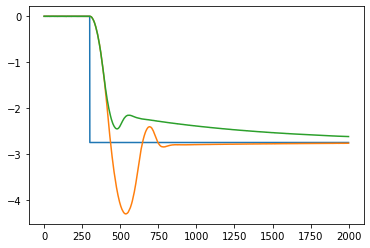

In [14]:
print(costinit)
print(costinitback)
plt.figure()
plt.plot(refs[1,:])
plt.plot(yinit[1,:])
plt.plot(yinitback[1,:])

In [15]:
# Initialize network
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

kpt = torch.tensor(kp,requires_grad=True)
kit = torch.tensor(ki,requires_grad=True)
kdt = torch.tensor(kd,requires_grad=True)
backt = torch.tensor(back,requires_grad=True)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

PIDparams = neuralPID()
#optimizer = torch.optim.Adam((PIDparams.parameters()), lr=0.1)
#for iters in range(1000):
#   kpt,kit,kdt = PIDparams(torch.randn(3,))
#   print(kpt,kit,kdt)
#   loss = (kpt-kpit)**2+(kit-kiit)**2+(kdt-kdit)**2
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()    
   #print(iters,loss) 

In [24]:
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))

optimizer = torch.optim.Adam((PIDparams.parameters()), lr=0.08)

smooth = 0.9
closs = 0
dtlossvals = []

for episodes in range(401):
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  ad = torch.div(Tft,(Tft+0.01))
  noise = 0.01*torch.randn(T,1)
  kpt = kpt.clone().detach()
  kit = kit.clone().detach()
  kdt = kdt.clone().detach()
  backt = backt.clone().detach()

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t]
    saterr = u-ucmd
    err = reft[t]-yt
    ninput = torch.cat((err.detach(),saterr.detach()),0)
    kpdt,kidt,kddt,backdt = PIDparams(ninput)
    kpt = smooth*kpt+(1-smooth)*(kpit+kpdt)
    kit = smooth*kit+(1-smooth)*(kiit+kidt)
    kdt = smooth*kdt+(1-smooth)*(kdit+kddt)
    backt = smooth*backt+(1-smooth)*(backit+backdt)
    xcont = xcont+kit*err+backt*saterr.detach()
    if(t>0):
      bd = torch.div(kdt,(Tft+0.01))
      D = ad*D-bd*(yt-yold);  
      ucmd = (0.01*xcont+kpt*(reft[t]-yt)+D)
      u = torch.clamp(ucmd,-3.0,3.0)
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  closs = closs+cost   
  if(episodes%120<20):
    print(episodes,cost)
  if(episodes%20==19):    
    dtlossvals.append(closs.clone().detach().numpy()[0]/20)
    closs = 0  
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

0 tensor([258.4409], grad_fn=<AddBackward0>)
1 tensor([46.0807], grad_fn=<AddBackward0>)
2 tensor([432.4080], grad_fn=<AddBackward0>)
3 tensor([49.3210], grad_fn=<AddBackward0>)
4 tensor([102.3574], grad_fn=<AddBackward0>)
5 tensor([61.3957], grad_fn=<AddBackward0>)
6 tensor([56.3813], grad_fn=<AddBackward0>)
7 tensor([231.1814], grad_fn=<AddBackward0>)
8 tensor([586.0457], grad_fn=<AddBackward0>)
9 tensor([356.1272], grad_fn=<AddBackward0>)
10 tensor([44.5040], grad_fn=<AddBackward0>)
11 tensor([48.5438], grad_fn=<AddBackward0>)
12 tensor([44.5592], grad_fn=<AddBackward0>)
13 tensor([44.6255], grad_fn=<AddBackward0>)
14 tensor([159.3090], grad_fn=<AddBackward0>)
15 tensor([51.2267], grad_fn=<AddBackward0>)
16 tensor([65.9158], grad_fn=<AddBackward0>)
17 tensor([49.8989], grad_fn=<AddBackward0>)
18 tensor([347.0166], grad_fn=<AddBackward0>)
19 tensor([200.4461], grad_fn=<AddBackward0>)
120 tensor([46.3638], grad_fn=<AddBackward0>)
121 tensor([44.3111], grad_fn=<AddBackward0>)
122 tenso

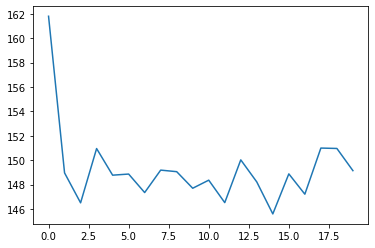

In [25]:
plt.figure()
plt.plot(dtlossvals)

torch.save(PIDparams.state_dict(), "./datafiles/sodunstablegradientparams")

In [26]:
kpst = torch.tensor(kp,requires_grad=True)
kist = torch.tensor(ki,requires_grad=True)
kdst = torch.tensor(kd,requires_grad=True)
backst = torch.tensor(back,requires_grad=True)
Tft = torch.tensor(Tf,requires_grad=True)
optimizer = torch.optim.Adam((kpst,kist,kdst,backst), lr=0.08)

stlossvals = []
closs = 0
kptrain = []
kitrain = []
kdtrain = []
backtrain = []
for episodes in range(401):
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  ucmd = torch.tensor([0.0],requires_grad=True)
  u = torch.tensor([0.0],requires_grad=True)  
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdst,(Tft+0.01))
  noise = 0.01*torch.randn(T,1)
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kist*(reft[t]-yt)+backst*saterr
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpst*(reft[t]-yt)+D)
    u = torch.clamp(ucmd,-3.0,3.0)
    uvalssat[i] = u;
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  closs = closs+cost 
  if(episodes%20==19):
    stlossvals.append(closs.clone().detach().numpy()[0]/20)
    closs = 0
  kptrain.append(kpst.clone().detach().numpy())
  kitrain.append(kist.clone().detach().numpy())
  kdtrain.append(kdst.clone().detach().numpy())
  backtrain.append(backst.clone().detach().numpy())  
  if(episodes%60<20):
    #print(kpt,kdt,kit,Tft)
    print(episodes,cost,backst) 
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
print(kpst,kist,kdst,backst)

0 tensor([54.1005], grad_fn=<AddBackward0>) tensor(1., requires_grad=True)
1 tensor([635.9478], grad_fn=<AddBackward0>) tensor(0.9200, requires_grad=True)
2 tensor([49.4884], grad_fn=<AddBackward0>) tensor(0.8567, requires_grad=True)
3 tensor([45.1280], grad_fn=<AddBackward0>) tensor(0.8048, requires_grad=True)
4 tensor([487.6638], grad_fn=<AddBackward0>) tensor(0.7617, requires_grad=True)
5 tensor([283.1970], grad_fn=<AddBackward0>) tensor(0.7054, requires_grad=True)
6 tensor([47.5870], grad_fn=<AddBackward0>) tensor(0.6492, requires_grad=True)
7 tensor([45.1751], grad_fn=<AddBackward0>) tensor(0.5995, requires_grad=True)
8 tensor([100.6756], grad_fn=<AddBackward0>) tensor(0.5557, requires_grad=True)
9 tensor([265.4712], grad_fn=<AddBackward0>) tensor(0.5171, requires_grad=True)
10 tensor([169.7800], grad_fn=<AddBackward0>) tensor(0.4825, requires_grad=True)
11 tensor([211.6555], grad_fn=<AddBackward0>) tensor(0.4530, requires_grad=True)
12 tensor([46.9970], grad_fn=<AddBackward0>) te

302 tensor([45.3934], grad_fn=<AddBackward0>) tensor(0.5629, requires_grad=True)
303 tensor([48.3398], grad_fn=<AddBackward0>) tensor(0.5656, requires_grad=True)
304 tensor([158.8260], grad_fn=<AddBackward0>) tensor(0.5680, requires_grad=True)
305 tensor([293.6946], grad_fn=<AddBackward0>) tensor(0.5706, requires_grad=True)
306 tensor([269.2207], grad_fn=<AddBackward0>) tensor(0.5743, requires_grad=True)
307 tensor([44.7429], grad_fn=<AddBackward0>) tensor(0.5824, requires_grad=True)
308 tensor([66.2610], grad_fn=<AddBackward0>) tensor(0.5902, requires_grad=True)
309 tensor([587.7269], grad_fn=<AddBackward0>) tensor(0.5986, requires_grad=True)
310 tensor([45.0206], grad_fn=<AddBackward0>) tensor(0.6131, requires_grad=True)
311 tensor([173.0474], grad_fn=<AddBackward0>) tensor(0.6264, requires_grad=True)
312 tensor([47.0920], grad_fn=<AddBackward0>) tensor(0.6411, requires_grad=True)
313 tensor([46.2484], grad_fn=<AddBackward0>) tensor(0.6551, requires_grad=True)
314 tensor([47.1286], g

17.11736 3.7915268 5.48423 0.5383975


Text(0, 0.5, 'Back-calculation constant')

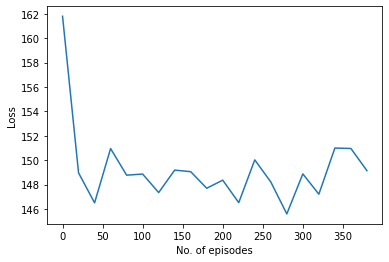

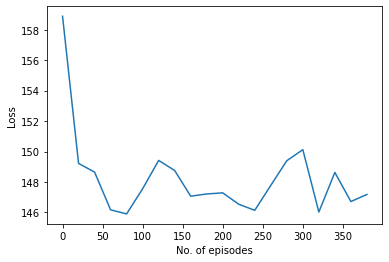

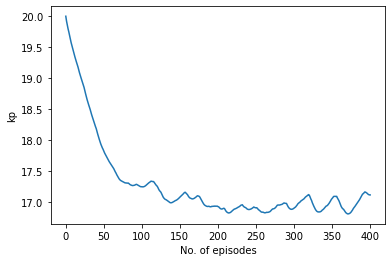

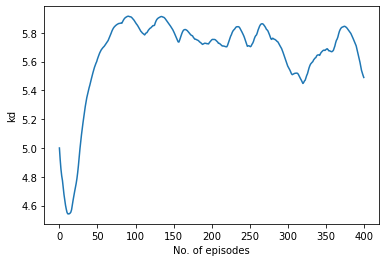

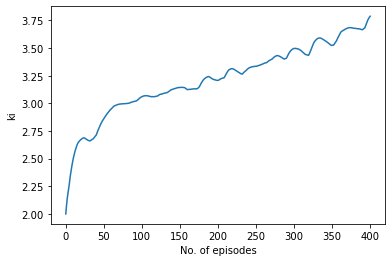

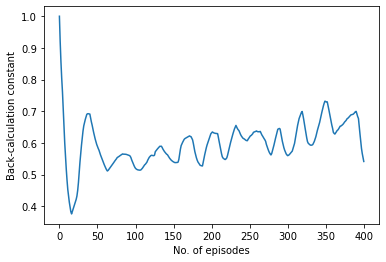

In [27]:
kps = kpst.detach().numpy()
kis = kist.detach().numpy()
kds = kdst.detach().numpy()
backs = backst.detach().numpy()
print(kps,kis,kds,backs)

plt.figure()
plt.plot(np.arange(len(dtlossvals))*20,dtlossvals)
plt.xlabel("No. of episodes")
plt.ylabel("Loss")

#plt.figure()
#plt.plot(np.arange(len(dftlossvals))*20,dftlossvals)
#plt.xlabel("No. of episodes")
#plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(stlossvals))*20,stlossvals)
plt.xlabel("No. of episodes")
plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(kptrain)),kptrain)
plt.xlabel("No. of episodes")
plt.ylabel("kp")

plt.figure()
plt.plot(np.arange(len(kdtrain)),kdtrain)
plt.xlabel("No. of episodes")
plt.ylabel("kd")

plt.figure()
plt.plot(np.arange(len(kitrain)),kitrain)
plt.xlabel("No. of episodes")
plt.ylabel("ki")

plt.figure()
plt.plot(np.arange(len(backtrain)),backtrain)
plt.xlabel("No. of episodes")
plt.ylabel("Back-calculation constant")

In [28]:
costdgradient = np.zeros((30,))
costinit = np.zeros((30,))
costinitback = np.zeros((30,))
costsgradient = np.zeros((30,))
costdfgradient = np.zeros((30,))

ydgradient = np.zeros((30,T))
udgradient = np.zeros((30,T))

ysgradient = np.zeros((30,T))
usgradient = np.zeros((30,T))


#ydfgradient = np.zeros((10,T))
#udfgradient = np.zeros((10,T))

kpdgradient = np.zeros((30,T))
kidgradient = np.zeros((30,T))
kddgradient = np.zeros((30,T))
backdgradient = np.zeros((30,T))
#PIDparams = neuralPID()
#PIDparams.load_state_dict(torch.load("dgradientparams"))

yinit = np.zeros((30,T))
uinit = np.zeros((30,T))

yinitback = np.zeros((30,T))
uinitback = np.zeros((30,T))
smooth = 0.9

for iters in range(0,30):
  ref = refs[iters,:]
  reft = torch.tensor(ref)
  noise = 0.0005*torch.randn(T,1)  
  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    ydgradient[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    err = reft[t]-yt
    ninput = torch.cat((err.detach(),saterr.detach()),0)
    kpdt,kidt,kddt,backdt = PIDparams(ninput)
    kpt = smooth*kpt+(1-smooth)*(kpit+kpdt)
    kit = smooth*kit+(1-smooth)*(kiit+kidt)
    kdt = smooth*kdt+(1-smooth)*(kdit+kddt)
    backt = smooth*backt+(1-smooth)*(backit+backdt)
    xcont = xcont+kit*err+backt*saterr.detach()
    if(t>0):
      bd = torch.div(kdt,(Tft+0.01))
      D = ad*D-bd*(yt-yold);  
      ucmd = (0.01*xcont+kpt*(reft[t]-yt)+D)
      u = torch.clamp(ucmd,-3.0,3.0)
      udgradient[iters,t] = u.clone().detach().numpy()
      kpdgradient[iters,t] = kpt.clone().detach().numpy()
      kidgradient[iters,t] = kit.clone().detach().numpy()
      kddgradient[iters,t] = kdt.clone().detach().numpy()
      backdgradient[iters,t] = backt.clone().detach().numpy()  
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
    
  costdgradient[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinit[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+err
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       u = (0.01*kiit*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(u,-3.0,3.0)
    uinit[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinit[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdst,(Tft+0.01))

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    ysgradient[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kist*(reft[t]-yt)+backst*saterr.detach()
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpst*(reft[t]-yt)+D)
    u = torch.clamp(ucmd,-3.0,3.0)
    usgradient[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costsgradient[iters] = cost.detach().numpy() 

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdit,(Tft+0.01))

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinitback[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kiit*(reft[t]-yt)+backit*saterr.detach()
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpit*(reft[t]-yt)+D)
    u = torch.clamp(ucmd,-3.0,3.0)
    usgradient[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinitback[iters] = cost.detach().numpy()

  #xcont = torch.tensor([0.0],requires_grad=True)
  #x = torch.tensor([[0.0],[0.0]],requires_grad=True)  
  #u = torch.tensor([0.0],requires_grad=True)
  #u2 = torch.tensor([0.0],requires_grad=True)
  #u1 = torch.tensor([0.0],requires_grad=True)     
  #cost = torch.tensor([0.0],requires_grad=True)
  #yt = torch.tensor([0.0],requires_grad=True)
  #D  = torch.tensor([0.0],requires_grad=False)
  #satest = torch.zeros(500,requires_grad=False)
  #ad = torch.div(Tft,(Tft+0.01))
  #bd = torch.div(kddft,(Tft+0.01))
    
  #for t in range(T):
  #  yold = yt
  #  yt = torch.matmul(systC.float(),x)+noise[t]
  #  ydfgradient[iters,t] = yt.clone().detach().numpy()
  #  satest = torch.roll(satest,1)
  #  satest[0] = u-ucmd
  #  xcont = xcont+kidft*(reft[t]-yt)
  #  if(t>0):
  #     D = ad*D-bd*(yt-yold);  
  #     ucmd = (0.01*xcont+kpdft*(reft[t]-yt)+D+0.01*torch.dot(backdft,satest.detach()))
  #  u = torch.clamp(ucmd,-3.0,3.0)
  #  x = torch.matmul(systA.float(),x)+systB.float()*u
  #  cost = cost+(reft[t]-yt)**2
  #costdfgradient[iters] = cost.detach().numpy()

In [29]:
print("Dgradient-dynamic",costdgradient)
print("Dgradient-static",costsgradient)
print("Initial",costinit)
print("Initial-backcalculation",costinitback)

print("Dgradient-dynamic",np.mean(costdgradient[0:20]),np.std(costdgradient[0:20]))
print("Dgradient-static",np.mean(costsgradient[0:20]),np.std(costsgradient[0:20]))
print("Initial",np.mean(costinit[0:20]),np.std(costinit[0:20]))
print("Initial-backcalculation",np.mean(costinitback[0:20]),np.std(costinitback[0:20]))

print("Dgradient-dynamic",np.mean(costdgradient[20:30]),np.std(costdgradient[20:30]))
print("Dgradient-static",np.mean(costsgradient[20:30]),np.std(costsgradient[20:30]))
print("Initial",np.mean(costinit[20:30]),np.std(costinit[20:30]))
print("Initial-backcalculation",np.mean(costinitback[20:30]),np.std(costinitback[20:30]))

Dgradient-dynamic [ 44.47478867 551.50714111  45.57603455  44.35264587  44.61316299
  44.38525391 169.11204529  45.69119644  64.38499451  93.86367798
  45.69622803  45.78923798 287.34368896  45.74621201 199.67478943
 159.6260376  270.58886719  44.43984604 256.4057312  408.81869507
  45.55402374 443.37432861  44.60329056 368.53710938 303.44940186
  45.91905212 140.53445435 343.90203857 147.43829346  44.33840942]
Dgradient-static [ 44.58052826 556.63671875  44.49012375  44.53453064  44.62245941
  44.51730728 169.51548767  44.6113205   64.52272034  94.04125214
  44.57313538  44.61334229 288.78012085  44.58821106 200.25572205
 155.41560364 266.99691772  44.54838562 253.04110718 411.36114502
  44.49020767 447.16799927  44.65683365 370.712677   304.6137085
  44.65291214 140.62384033 346.67837524 147.86804199  44.51181412]
Initial [ 47.37983704 812.68475342  47.30961609  47.32543945  47.4021492
  47.31519318 204.09127808  47.40436554  70.37220001 106.17243195
  47.39306259  47.42606735 375.11

Text(0, 0.5, 'Back-calculation gain')

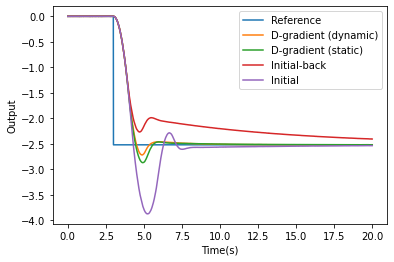

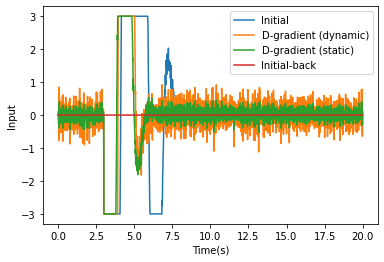

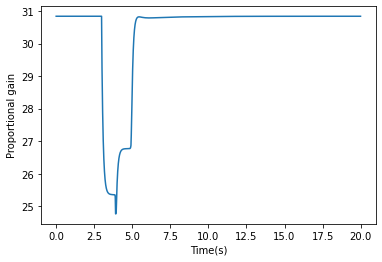

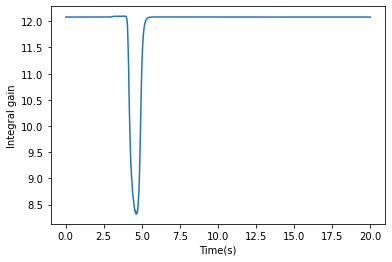

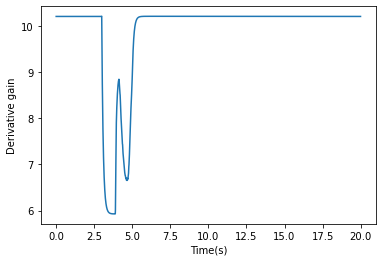

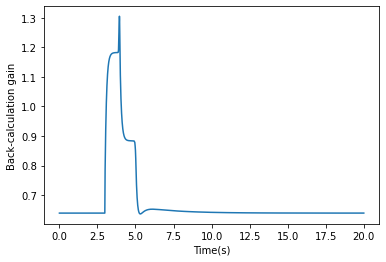

In [30]:
plt.figure()
plt.plot(0.01*np.arange(0,T),refs[21,:])
plt.plot(0.01*np.arange(0,T),ydgradient[21,:])
plt.plot(0.01*np.arange(0,T),ysgradient[21,:])
plt.plot(0.01*np.arange(0,T),yinitback[21,:])
plt.plot(0.01*np.arange(0,T),yinit[21,:])
plt.xlabel("Time(s)")
plt.ylabel("Output")
plt.legend(["Reference","D-gradient (dynamic)","D-gradient (static)","Initial-back","Initial"])

plt.figure()
plt.plot(0.01*np.arange(0,T),uinit[21,:])
plt.plot(0.01*np.arange(0,T),udgradient[21,:])
plt.plot(0.01*np.arange(0,T),usgradient[21,:])
plt.plot(0.01*np.arange(0,T),uinitback[21,:])
plt.xlabel("Time(s)")
plt.ylabel("Input")
plt.legend(["Initial","D-gradient (dynamic)","D-gradient (static)","Initial-back"])

plt.figure()
plt.plot(0.01*np.arange(1,T),kpdgradient[21,1:])
plt.xlabel("Time(s)")
plt.ylabel("Proportional gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),kidgradient[21,1:])
plt.xlabel("Time(s)")
plt.ylabel("Integral gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),kddgradient[21,1:])
plt.xlabel("Time(s)")
plt.ylabel("Derivative gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),backdgradient[21,1:])
plt.xlabel("Time(s)")
plt.ylabel("Back-calculation gain")

In [31]:
# Save everything
np.save("./datafiles/soddunstabledtlossvals",dtlossvals)
np.save("./datafiles/soddunstablestlossvals",stlossvals)
#np.save("sodddftlossvals",dftlossvals)
np.save("./datafiles/soddunstableydgradient",ydgradient)
np.save("./datafiles/soddunstableyinitback",yinitback)
np.save("./datafiles/soddunstableysgradient",ysgradient)
np.save("./datafiles/soddunstableyinit",yinit)
np.save("./datafiles/soddunstableudgradient",udgradient)
np.save("./datafiles/soddunstableuinitback",uinitback)
np.save("./datafiles/soddunstableusgradient",usgradient)
np.save("./datafiles/soddunstableuinit",uinit)
np.save("./datafiles/soddunstablekpdgradient",kpdgradient)
np.save("./datafiles/soddunstablekidgradient",kidgradient)
np.save("./datafiles/soddunstablekddgradient",kddgradient)
np.save("./datafiles/soddunstablebackdgradient",backdgradient)
np.save("./datafiles/soddunstablekptrain",kptrain)
np.save("./datafiles/soddunstablekitrain",kitrain)
np.save("./datafiles/soddunstablekdtrain",kdtrain)
np.save("./datafiles/soddunstablebacktrain",backtrain)
np.save("./datafiles/soddunstablerefs",refs)
np.save("./datafiles/soddunstablecostdgradient",costdgradient)
np.save("./datafiles/soddunstablecostinitback",costinitback)
np.save("./datafiles/soddunstablecostsgradient",costsgradient)
np.save("./datafiles/soddunstablecostinit",costinit)

In [32]:
dtlossvals = np.load("./datafiles/soddunstabledtlossvals.npy")
stlossvals = np.load("./datafiles/soddunstablestlossvals.npy")
ydgradient = np.load("./datafiles/soddunstableydgradient.npy")
ysgradient = np.load("./datafiles/soddunstableysgradient.npy")
yinit = np.load("./datafiles/soddunstableyinit.npy")
yinitback = np.load("./datafiles/soddunstableyinitback.npy")
udgradient = np.load("./datafiles/soddunstableudgradient.npy")
usgradient = np.load("./datafiles/soddunstableusgradient.npy")
uinit = np.load("./datafiles/soddunstableuinit.npy")
uinitback = np.load("./datafiles/soddunstableuinitback.npy")
kpdgradient = np.load("./datafiles/soddunstablekpdgradient.npy")
kidgradient = np.load("./datafiles/soddunstablekidgradient.npy")
kddgradient = np.load("./datafiles/soddunstablekddgradient.npy")
backdgradient = np.load("./datafiles/soddunstablebackdgradient.npy")
kptrain = np.load("./datafiles/soddunstablekptrain.npy")
kitrain = np.load("./datafiles/soddunstablekitrain.npy")
backtrain = np.load("./datafiles/soddunstablebacktrain.npy")
refs = np.load("./datafiles/soddunstablerefs.npy")
costdgradient = np.load("./datafiles/soddunstablecostdgradient.npy")
costsgradient = np.load("./datafiles/soddunstablecostsgradient.npy")
costinit = np.load("./datafiles/soddunstablecostinit.npy")
costinitback = np.load("./datafiles/soddunstablecostinitback.npy")

In [36]:
print(udgradient.shape)
satpoints = np.argwhere(np.abs(udgradient[21,:])==3.0)

udsatpoints = np.zeros(udgradient[21,:].shape)
udsatpoints[satpoints] = 1

(30, 2000)


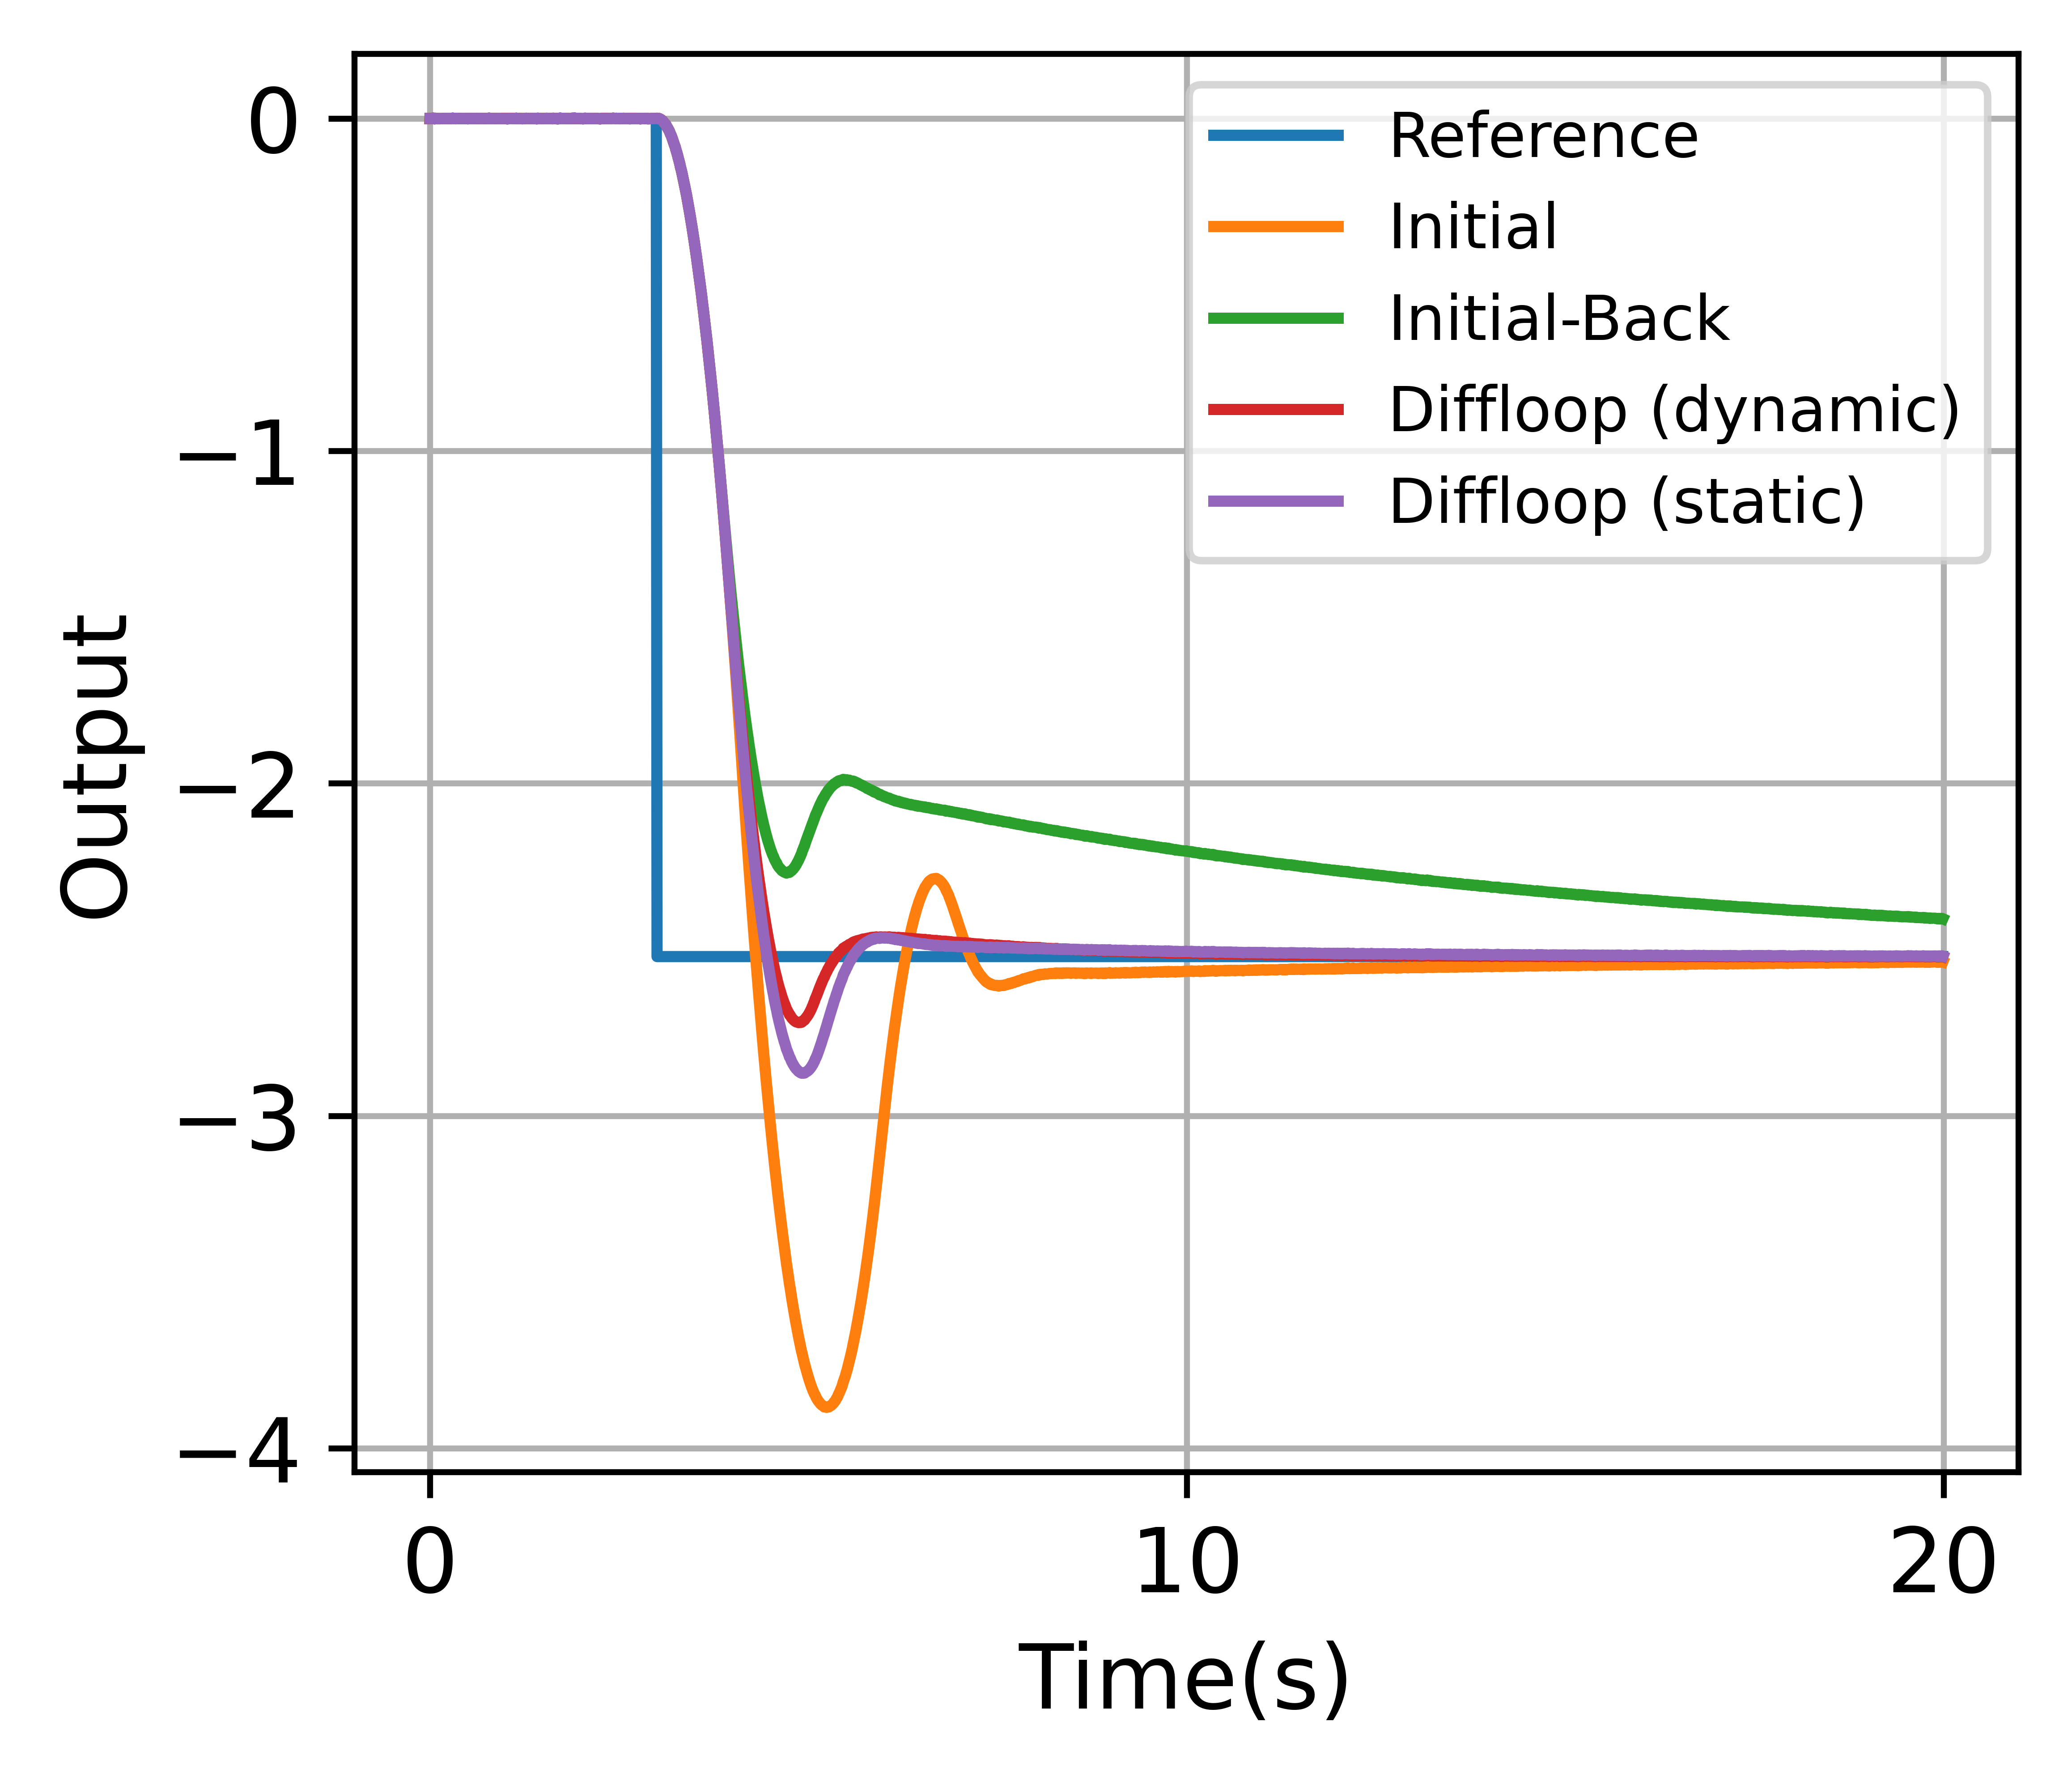

In [40]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.figure(dpi=1200,figsize=[4.0,3.5])
plt.plot(0.01*np.arange(0,T),refs[21,:])
plt.plot(0.01*np.arange(0,T),yinit[21,:])
plt.plot(0.01*np.arange(0,T),yinitback[21,:])
plt.plot(0.01*np.arange(0,T),ydgradient[21,:])
plt.plot(0.01*np.arange(0,T),ysgradient[21,:])
plt.xlabel("Time(s)",fontsize=12)
plt.ylabel("Output",fontsize=12)
plt.grid()
plt.legend(["Reference","Initial","Initial-Back","Diffloop (dynamic)","Diffloop (static)"],fontsize="small")

#plt.subplot(1,2,2)
#plt.plot(0.01*np.arange(0,T),uinit[21,:])
#plt.plot(0.01*np.arange(0,T),uinitback[21,:])
#plt.plot(0.01*np.arange(0,T),udgradient[21,:])
#plt.plot(0.01*np.arange(0,T),usgradient[21,:])
#plt.xlabel("Time(s)")
#plt.ylabel("Input")
#plt.legend(["Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"],fontsize="x-small")
plt.savefig("./figures/soddunstable1.pdf", facecolor='w', dpi=1200, edgecolor='b',orientation='portrait', format="pdf", bbox_inches=tr.Bbox([[-0.3,0],[4.0,3.5]]), 
            pad_inches=0.0)
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

#plt.figure()
#plt.plot(0.01*np.arange(0,T),uinit[21,:])
#plt.plot(0.01*np.arange(0,T),uinitback[21,:])
#plt.plot(0.01*np.arange(0,T),udgradient[21,:])
#plt.plot(0.01*np.arange(0,T),usgradient[21,:])
#plt.xlabel("Time(s)")
#plt.ylabel("Input")
#plt.legend(["Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"],fontsize="x-small")

plt.figure(dpi=1200,figsize=[17.5,10.5])
plt.subplot(2,2,1)
plt.plot(0.01*np.arange(1,T),kpdgradient[21,1:],'k',linewidth=4.0)
plt.fill_between(0.01*np.arange(0,T),24*udsatpoints,34*udsatpoints, facecolor='red', alpha=0.4)
plt.ylim([24,34])
plt.xlabel("Time(s)",fontsize=20)
plt.ylabel("Proportional gain",fontsize=20)
plt.grid()


plt.subplot(2,2,2)
plt.plot(0.01*np.arange(1,T),kidgradient[21,1:],'k',linewidth=4.0)
plt.fill_between(0.01*np.arange(0,T),6*udsatpoints,13*udsatpoints, facecolor='red', alpha=0.4)
plt.ylim([6,13])
plt.xlabel("Time(s)",fontsize=20)
plt.ylabel("Integral gain",fontsize=20)
plt.grid()

plt.subplot(2,2,3)
plt.plot(0.01*np.arange(1,T),kddgradient[21,1:],'k',linewidth=4.0)
plt.fill_between(0.01*np.arange(0,T),5*udsatpoints,12*udsatpoints, facecolor='red', alpha=0.4)
plt.ylim([5,12])
plt.xlabel("Time(s)",fontsize=20)
plt.ylabel("Derivative gain",fontsize=20)
plt.grid()

plt.subplot(2,2,4)
plt.plot(0.01*np.arange(1,T),backdgradient[21,1:],'k',linewidth=4.0)
plt.fill_between(0.01*np.arange(0,T),0.1*udsatpoints,3*udsatpoints, facecolor='red', alpha=0.4)
plt.ylim([0.1,3])
plt.xlabel("Time(s)",fontsize=20)
plt.ylabel("Back-calculation gain",fontsize=20)
plt.grid()
plt.savefig("./figures/soddunstable2.pdf", facecolor='w', dpi=1200, edgecolor='b',orientation='portrait', format="pdf", bbox_inches=tr.Bbox([[0,0],[17.5,10.5]]), 
            pad_inches=0.0)
